In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# 주식데이터 불러오기

### 종목코드와 링크 생성

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [3]:
#상장된 기업들목록에서 회사명과 종목코드만 가져옴
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2354 non-null   object
 1   code    2354 non-null   object
dtypes: object(2)
memory usage: 36.9+ KB


In [4]:
#회사명을 넣으면, code_df를 뒤져서 종목코드를 찾고, 네이버주식url에 덧대서 출력해주는 함수
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    code = code[1:7]
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url

item_name = '카카오'
url = get_url(item_name, code_df)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=035720


### 날짜별 종가, 전일비, 시가, 고가, 저가, 거래량 불러오기

In [5]:
def convert_col_name_kor_eng(df):  
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['date'], ascending=True) 
    df.head()
    return df

def get_dataset(num_date):
    df = pd.DataFrame()
    for page in range(1,num_date+1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df = df.dropna()
    df = convert_col_name_kor_eng(df)
    return df

df = get_dataset(300)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 4498 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3000 non-null   datetime64[ns]
 1   close   3000 non-null   int32         
 2   diff    3000 non-null   int32         
 3   open    3000 non-null   int32         
 4   high    3000 non-null   int32         
 5   low     3000 non-null   int32         
 6   volume  3000 non-null   int32         
dtypes: datetime64[ns](1), int32(6)
memory usage: 117.2 KB


### 데이터프레임 -> 넘파이

In [7]:
df = df.drop(['date'], axis=1)
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 4498 to 1
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   3000 non-null   int32
 1   diff    3000 non-null   int32
 2   open    3000 non-null   int32
 3   high    3000 non-null   int32
 4   low     3000 non-null   int32
 5   volume  3000 non-null   int32
dtypes: int32(6)
memory usage: 93.8 KB


In [8]:
print(df_size)

3000


In [9]:
train_set = df[0:int(df_size*0.7)]

In [10]:
test_set = df[int(df_size*0.7):]

In [11]:
train = train_set.to_numpy()
test = test_set.to_numpy()

In [12]:
print(train.shape)
print(test.shape)
print(train[1])
print(train[2])

(2100, 6)
(900, 6)
[ 61700    200  62000  62200  61100 133024]
[ 64600   2900  61700  64900  60100 337513]


# 데이터 전처리

#### minmax정규화, RNN용 shape으로 변경

In [13]:
def minmax_scaler(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

def build_dataset(time_series, seq_length):
    train_size = int(len(time_series - seq_length))
    dataX = []
    dataY = []

    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i + seq_length,1:]
        _y = time_series[i + seq_length,[0]]
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)
#2차원 배열 -> 넘파이배열로 변경시 자료의 사이즈가 맞지 않으면 object타입으로 처리해서 3차원배열로 인식하지 않는다.

In [14]:
train = minmax_scaler(train)
test_min = np.min(test, 0)
test_max = np.max(test, 0)
test_denom = test_max - test_min
test_minmax = (test-test_min) / (test_denom + 1e-7)#minmax_scaler(test) 
print(train_set.shape)
print(test_set.shape)

(2100, 6)
(900, 6)


In [15]:
seq_length = 7

In [72]:
trainX, trainY = build_dataset(train, seq_length)
testX, testY = build_dataset(test_minmax, seq_length)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(2093, 7, 5) (2093, 1)
(893, 7, 5) (893, 1)


### 넘파이 -> 텐서

In [17]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [18]:
def load(batch_size):
    transform = None
    train_set = data_loader(trainX, trainY, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_set = data_loader(testX, testY, transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 학습 모델

In [20]:
data_dim = 5
hidden_dim = 100
output_dim = 1
lr = 0.0001
epoch = 100

batch_size=512
layers=1

In [21]:
train_loader, test_loader= load(batch_size=batch_size)

In [22]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 25),# bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(25, output_dim)#, bias=True)
        )
    def forward(self, x):
        x, _status  = self.rnn(x)
        x = self.fc(x[:,-1])
        return x
              
model = Net(data_dim, hidden_dim, output_dim, layers).to(device)

In [23]:
loss_func = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
loss_arr = []
for i in range(epoch):
    for j, [x, y] in enumerate(train_loader):
        train_x = x.to(device).float()
        train_y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model.forward(train_x)
        
        #print(outputs.shape, train_y.shape)
        #print(outputs.dtype, train_y.dtype)
        
        loss = loss_func(outputs, train_y)
        #이걸 변수명을 같게하면 안되지!
        loss.backward()
        optimizer.step()
        loss_arr.append(loss)
    print(i, loss)

0 tensor(0.2801, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.2741, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.2826, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.2611, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.2657, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.2487, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.2350, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.2369, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.2323, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.2269, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.2338, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.2058, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.1934, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.1813, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.1762, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.1632, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.1586, 

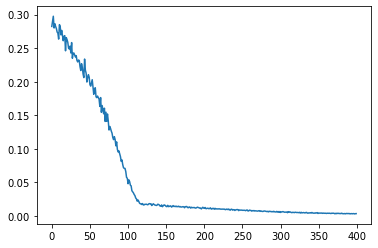

In [25]:
plt.plot(loss_arr)

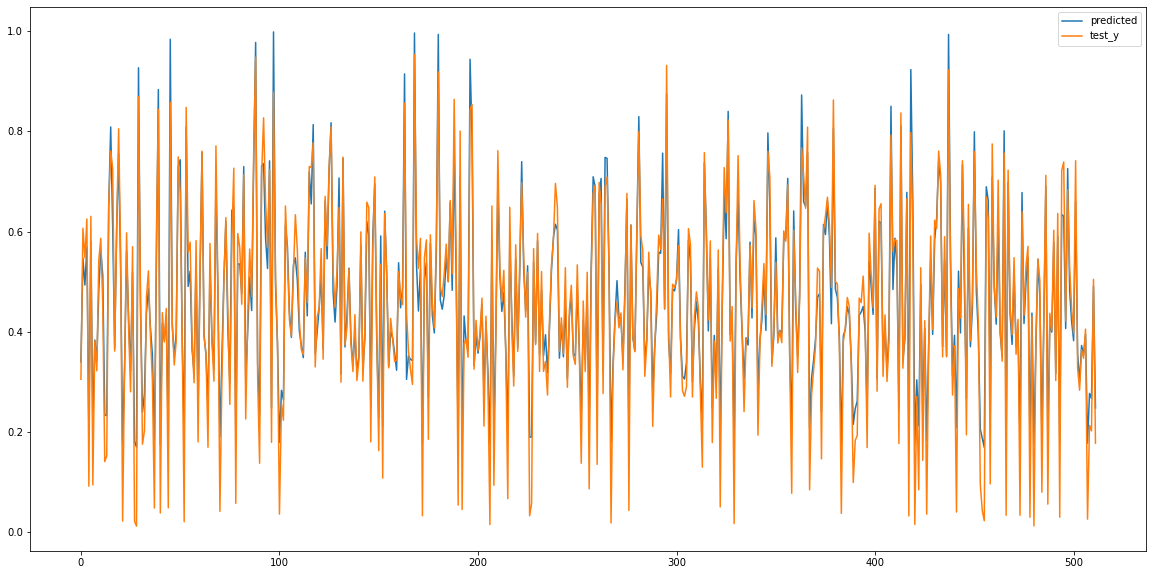

In [26]:
plt.figure(figsize=(20,10))
plt.plot(outputs.cpu().detach().numpy())
plt.plot(train_y.cpu().detach().numpy())
plt.legend(['predicted', 'test_y'])
plt.show()

## 모델 테스트

In [27]:
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [28]:
correct = 0
total = 0
loss_arr = []

model.eval()
with torch.no_grad():
    for j, [x, y] in enumerate(test_loader):
        #test_x = x.to(device).float()
        #test_y = y.to(device).float()
        test_x = testX_tensor.to(device).float()
        test_y = testY_tensor.to(device).float()
        predicted = model.forward(test_x)
        loss = loss_func(predicted, test_y)
        
        total += y.size(0)
        #print(y.shape, predicted.shape)
        #print(y, predicted)
        loss_arr.append(loss)
        print(i, loss)
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    #print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))

99 tensor(0.0026, device='cuda:0')
99 tensor(0.0026, device='cuda:0')


In [33]:
def show_result_graph(): 
    print(model)
    print('batch_size :',batch_size, ' layers: ', layers)
    plt.figure(figsize=(30,10))
    plt.plot(predicted.cpu())
    plt.plot(test_y.cpu())
    plt.legend(['predicted', 'test_y'])
    plt.grid(True)
    #plt.xticks([20*i for i in range(0,46)])
    plt.show()
    

Net(
  (rnn): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
batch_size : 256  layers:  1


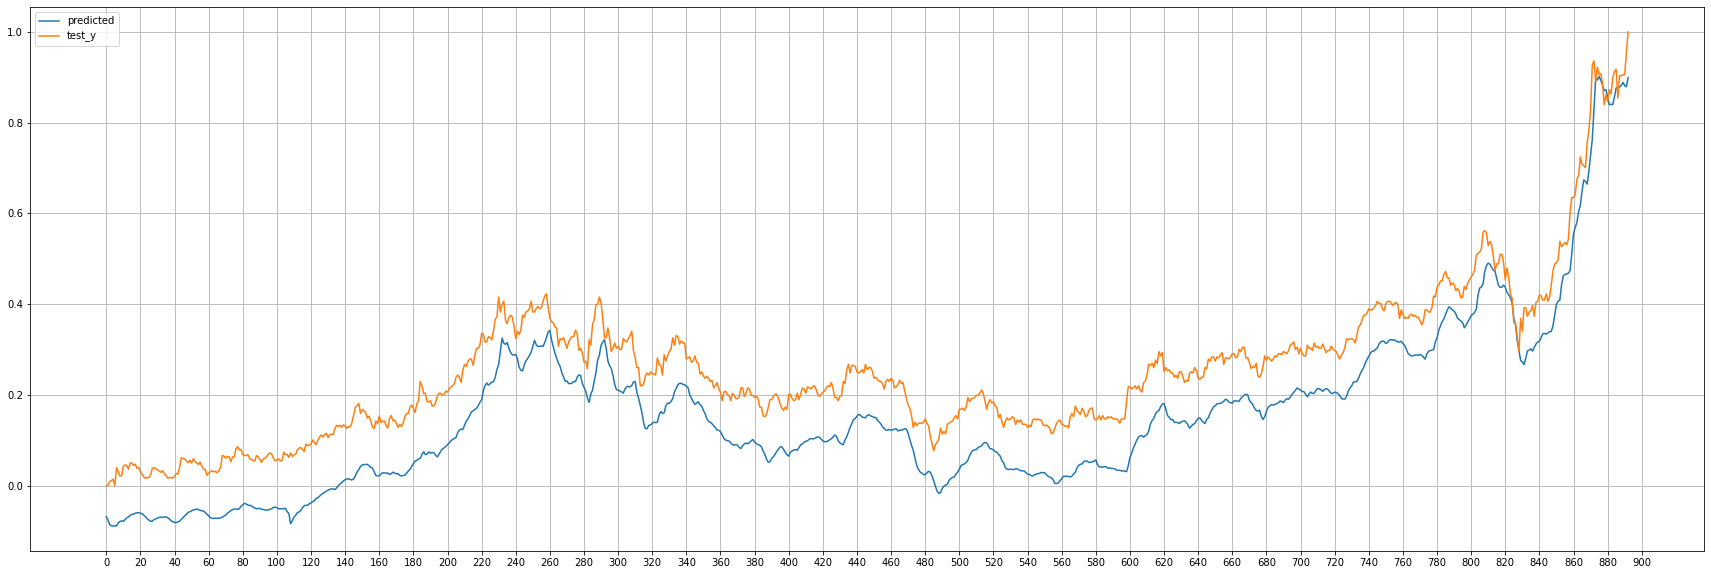

In [71]:
show_result_graph()

Net(
  (rnn): LSTM(5, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 256  layers:  1


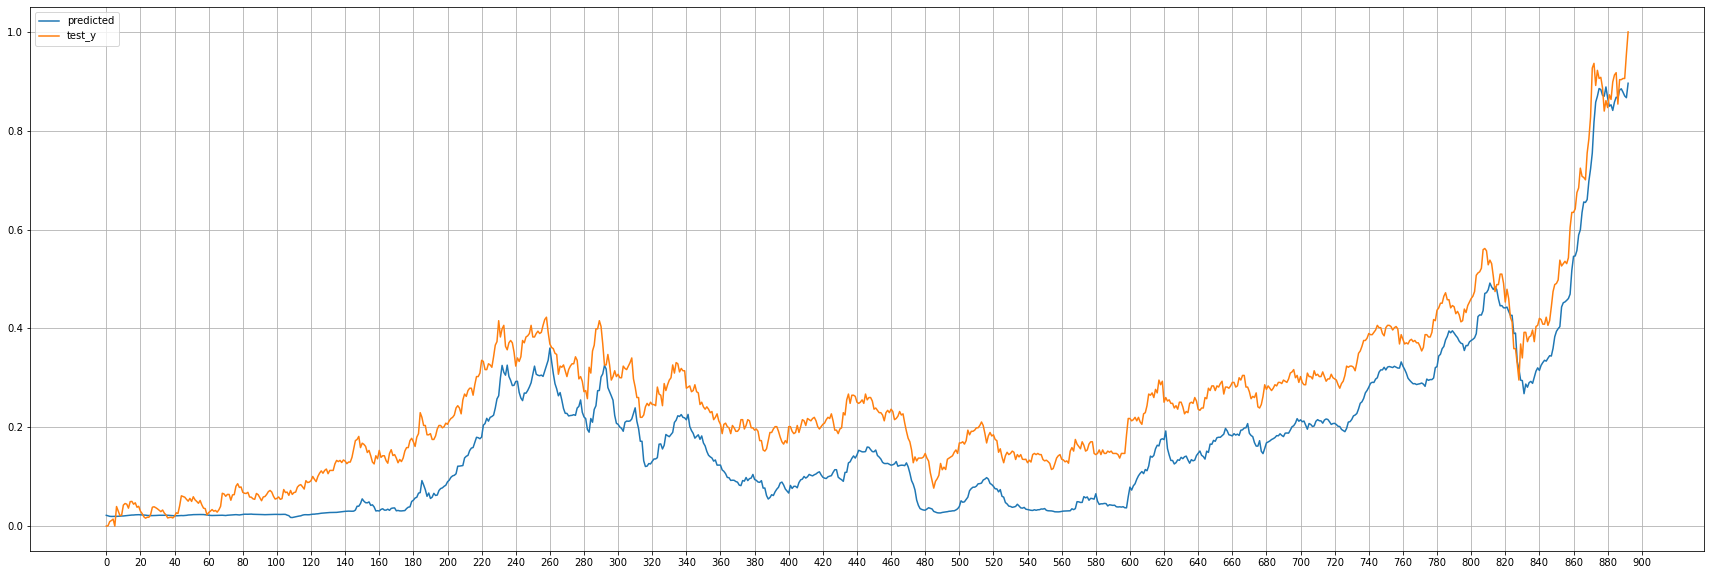

In [85]:
show_result_graph()

Net(
  (rnn): LSTM(5, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 256  layers:  1


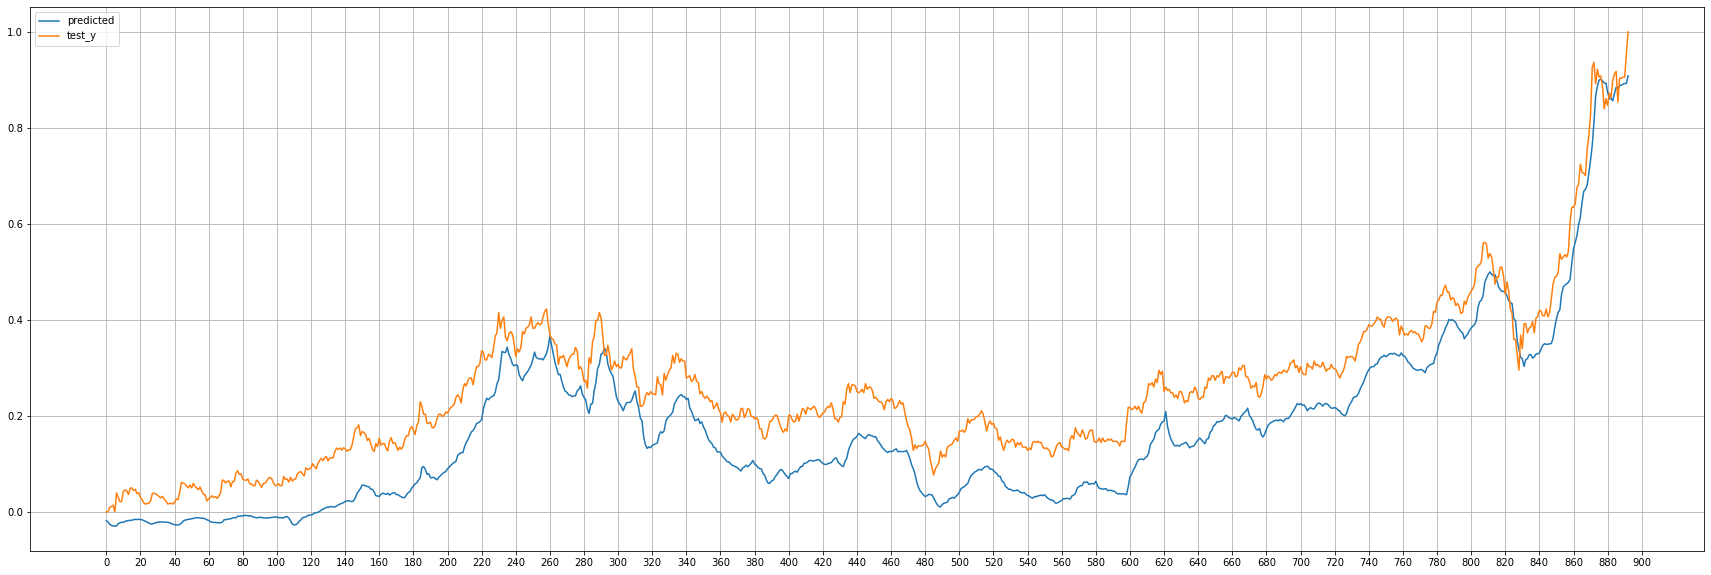

In [94]:
show_result_graph()

Net(
  (rnn): LSTM(5, 200, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 256  layers:  1


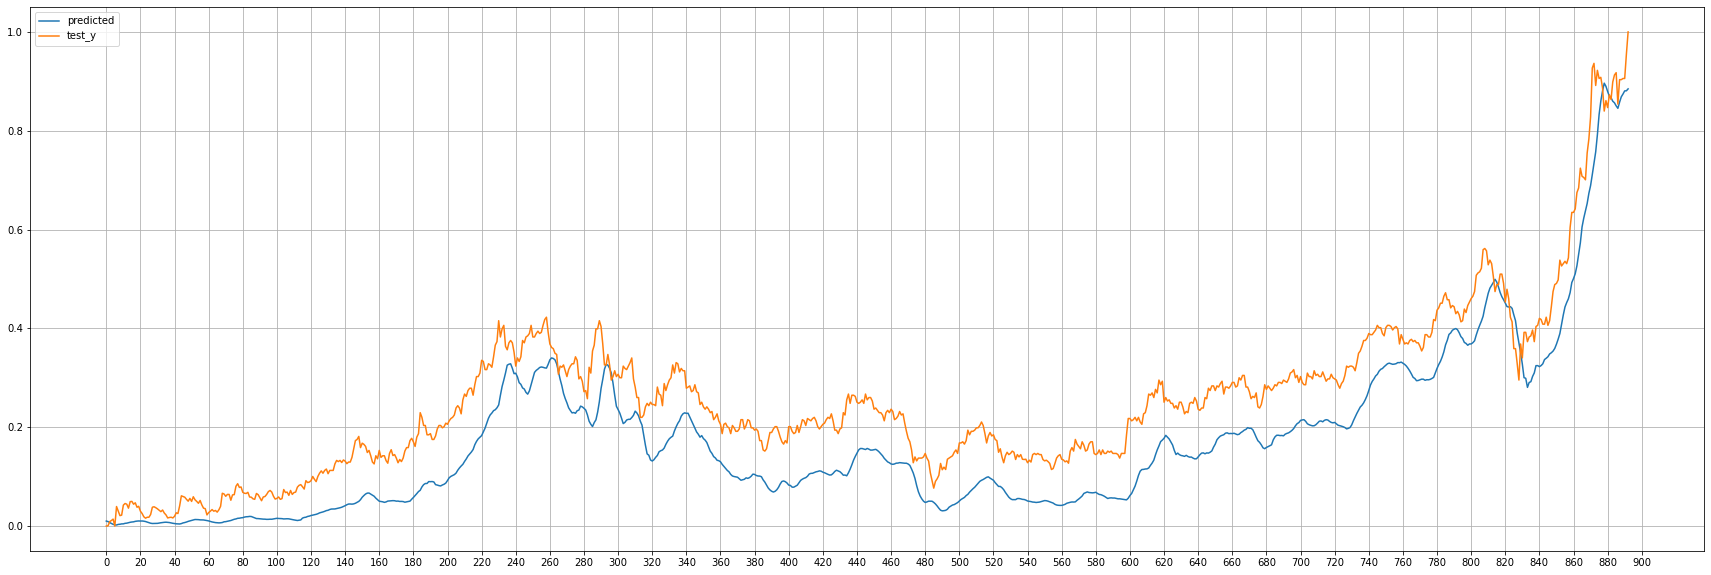

In [111]:
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 256  layers:  1


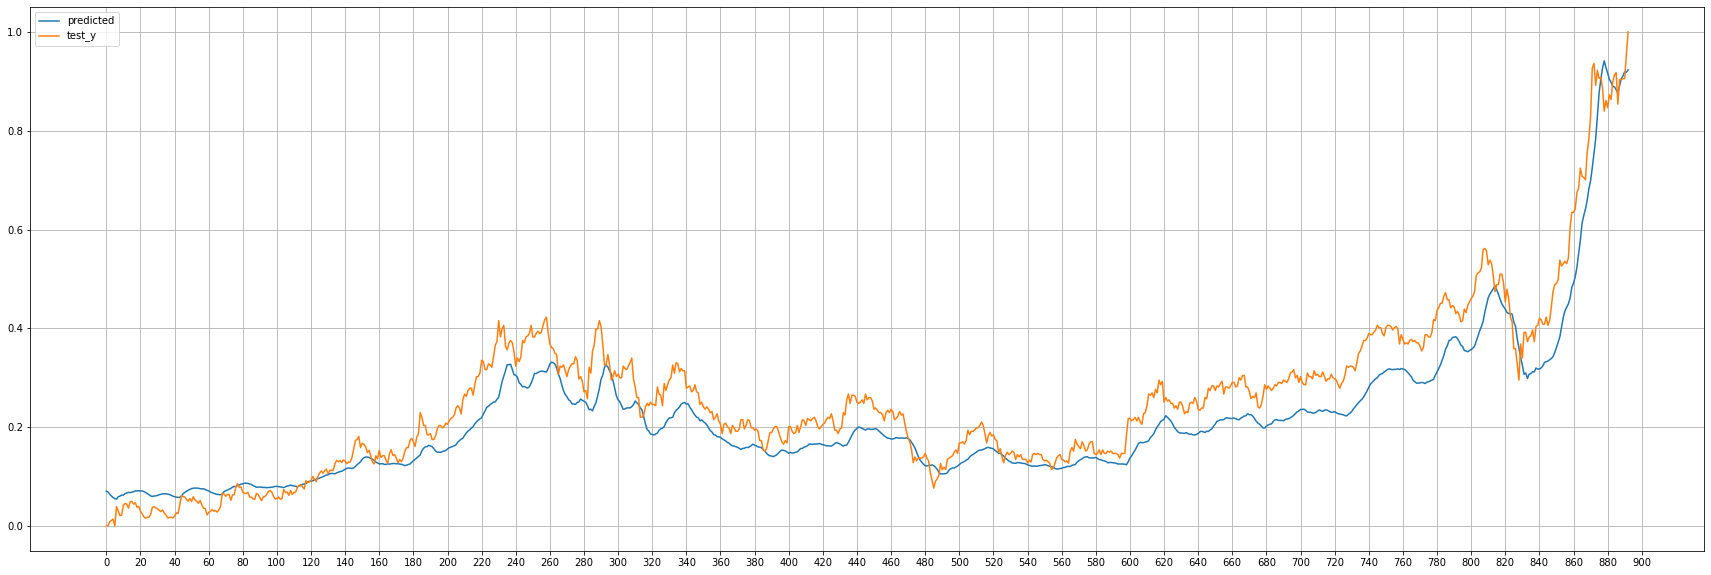

In [121]:
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 512  layers:  1


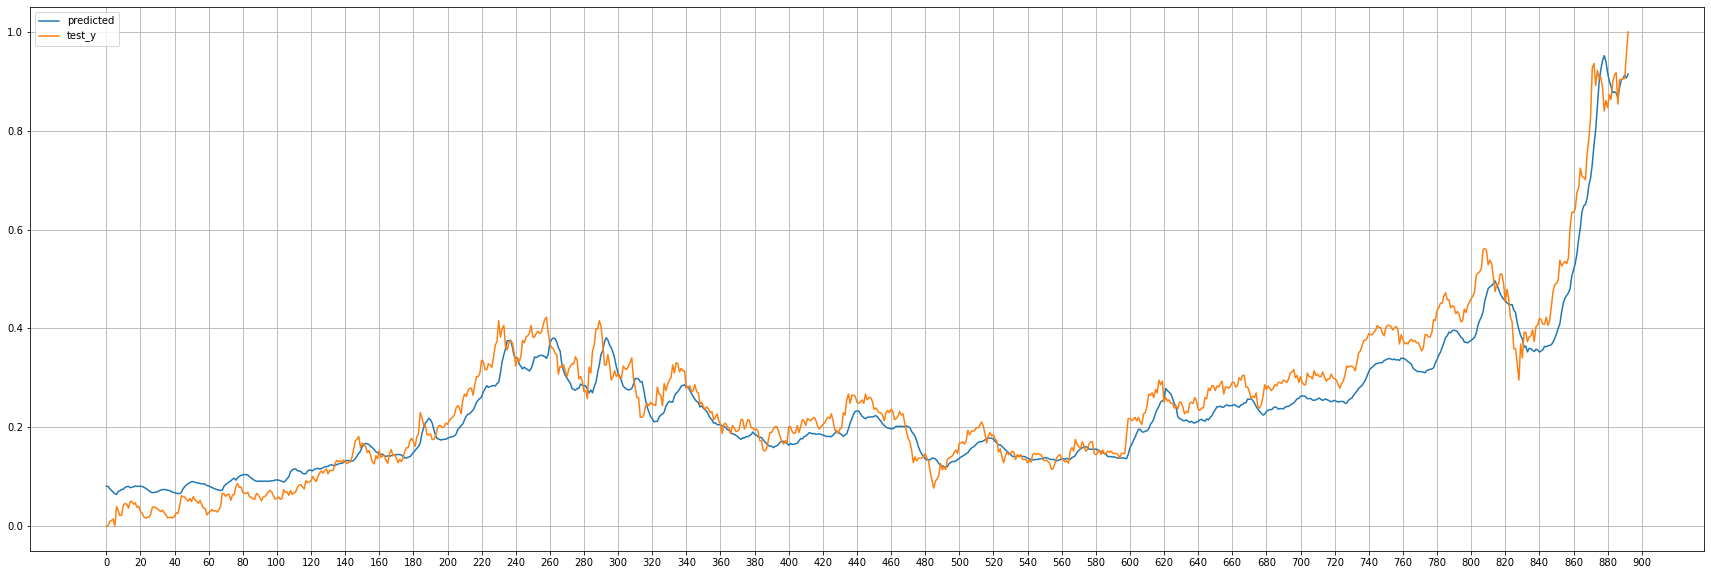

In [131]:
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 1024  layers:  1


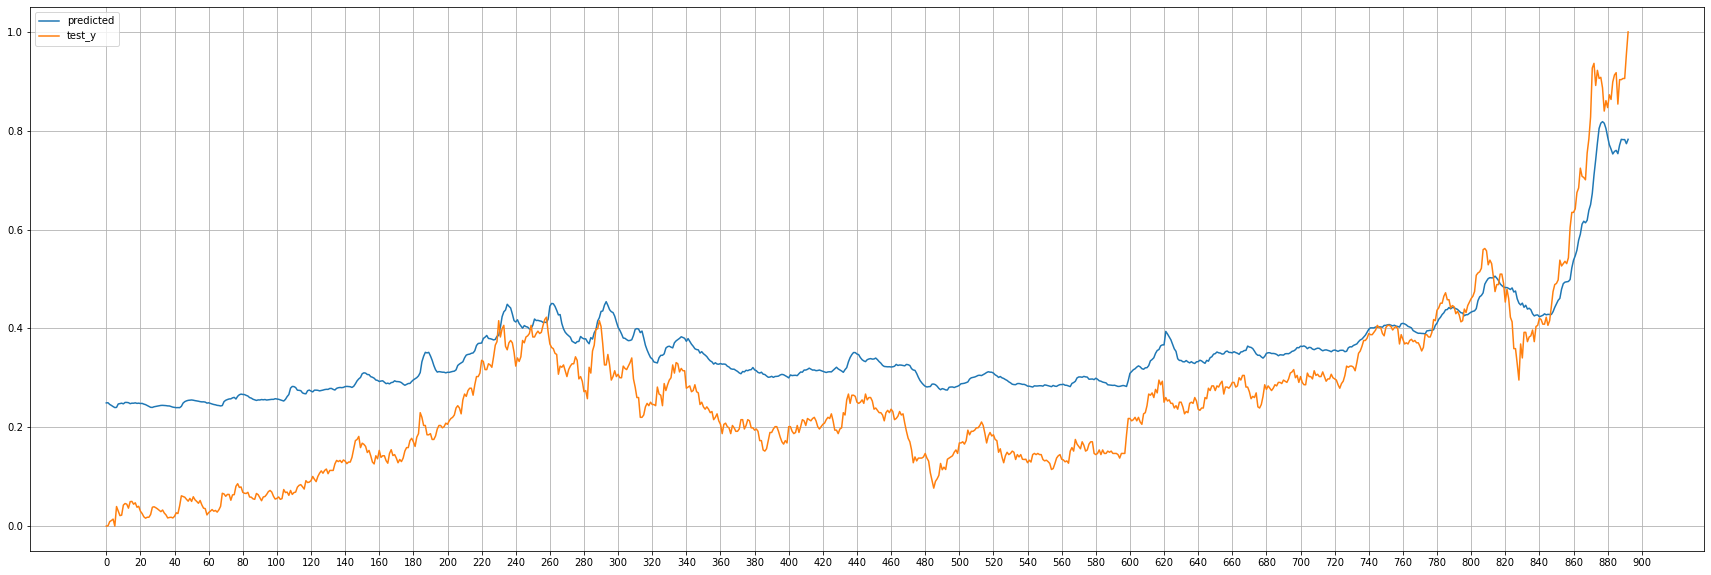

In [141]:
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 1024  layers:  1


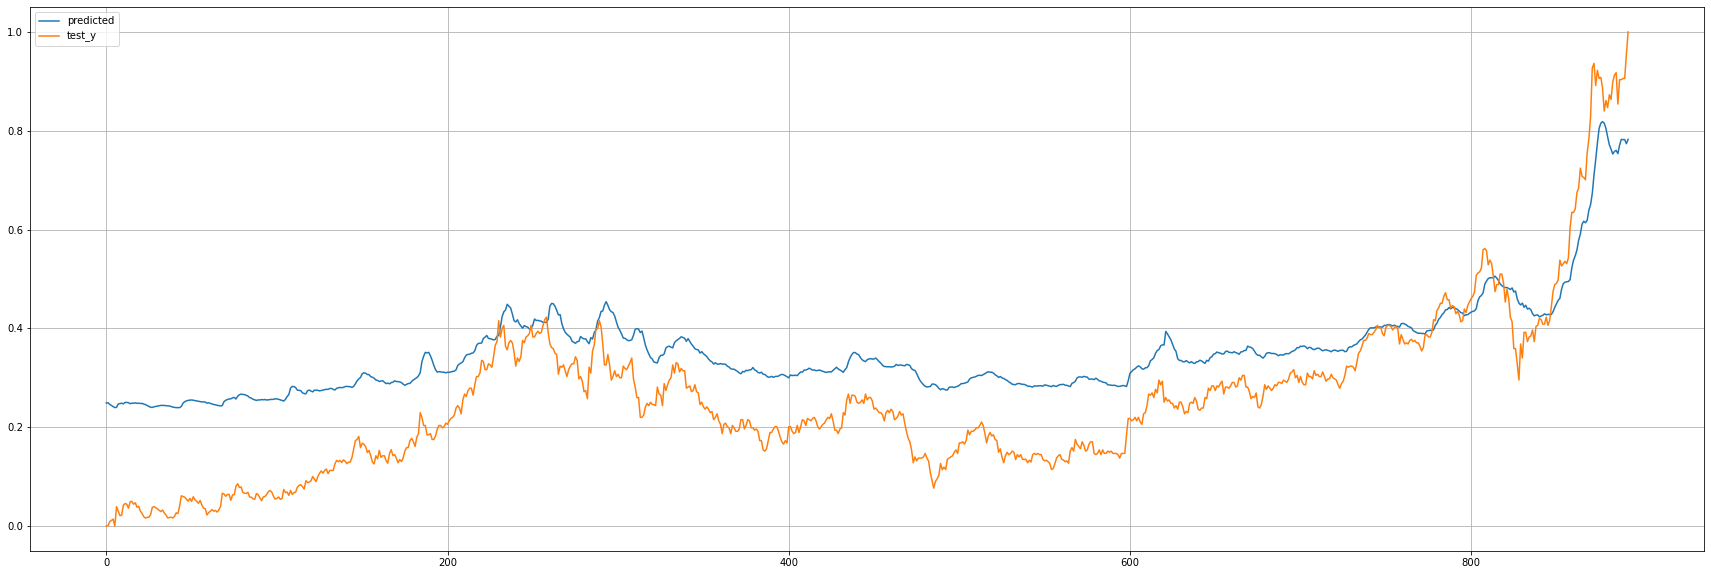

In [145]:
%matplotlib inline
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 512  layers:  1


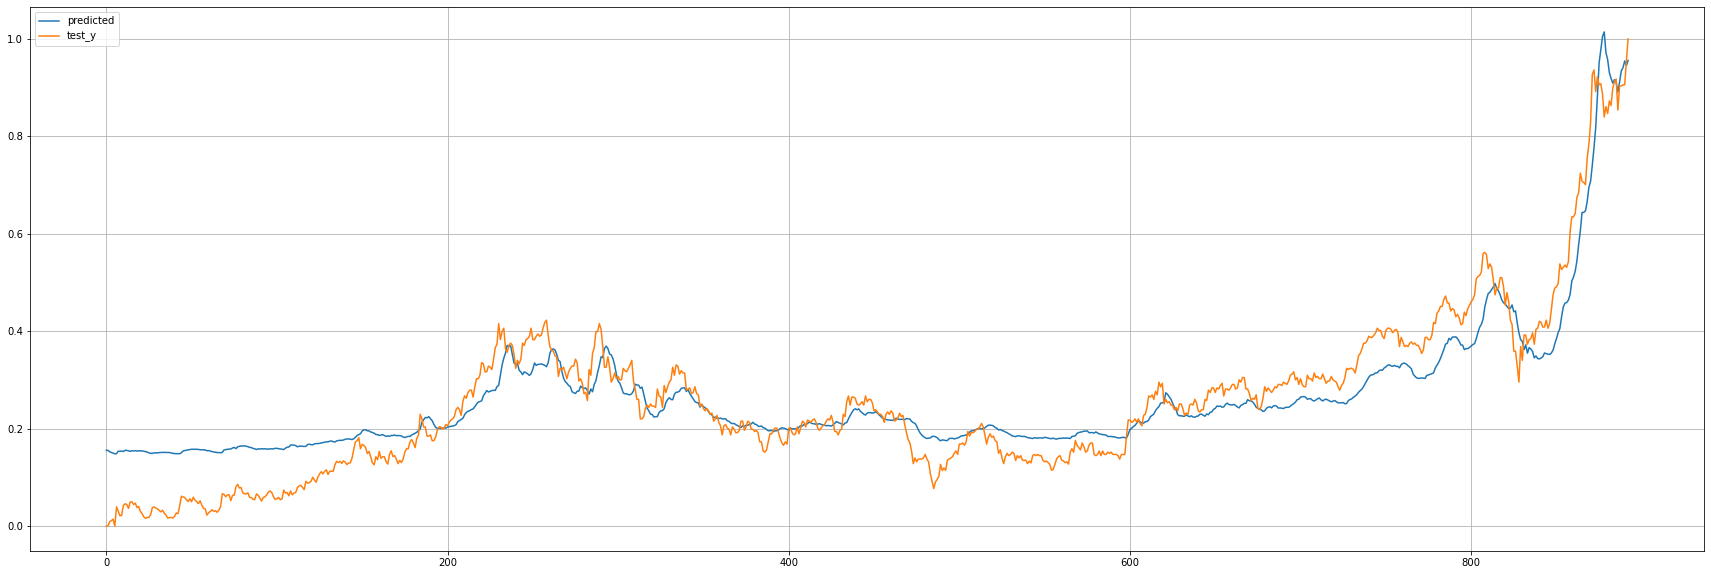

In [178]:
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 512  layers:  1


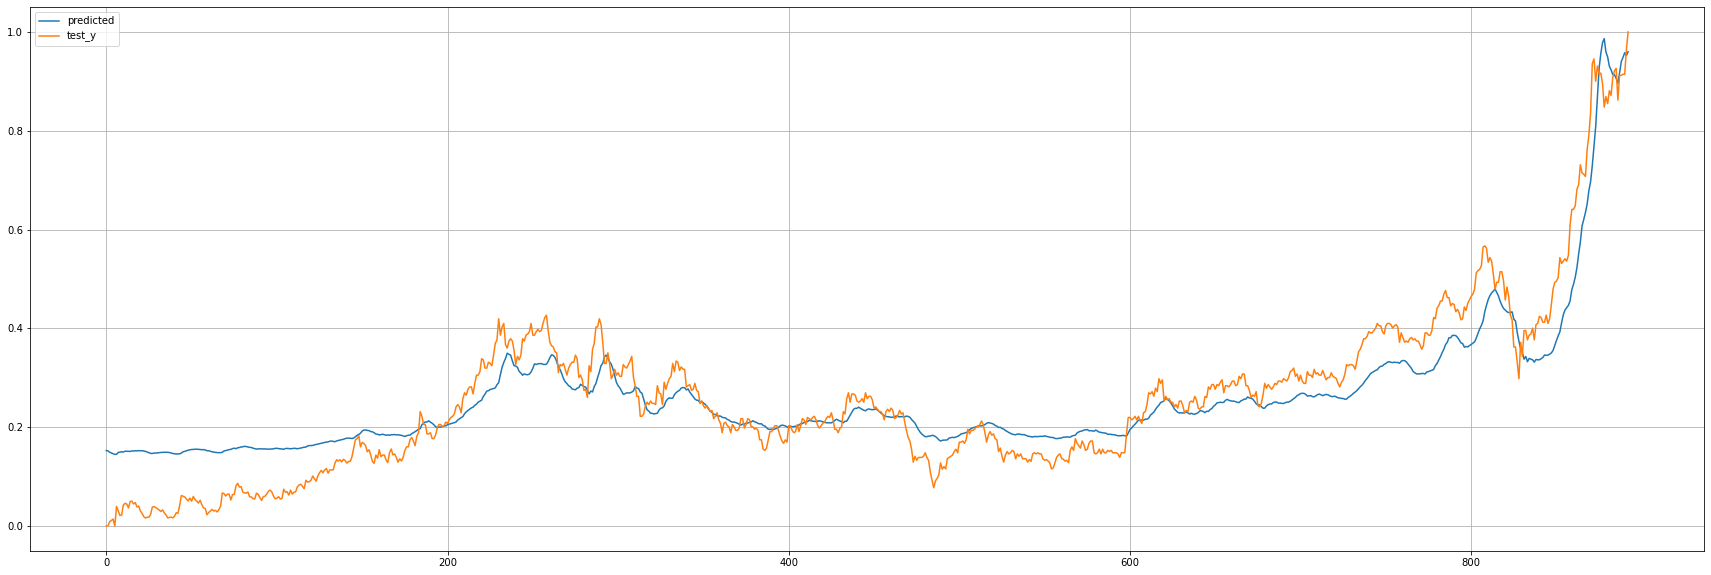

In [209]:
%matplotlib inline
show_result_graph()

Net(
  (rnn): LSTM(5, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 512  layers:  1


<IPython.core.display.Javascript object>


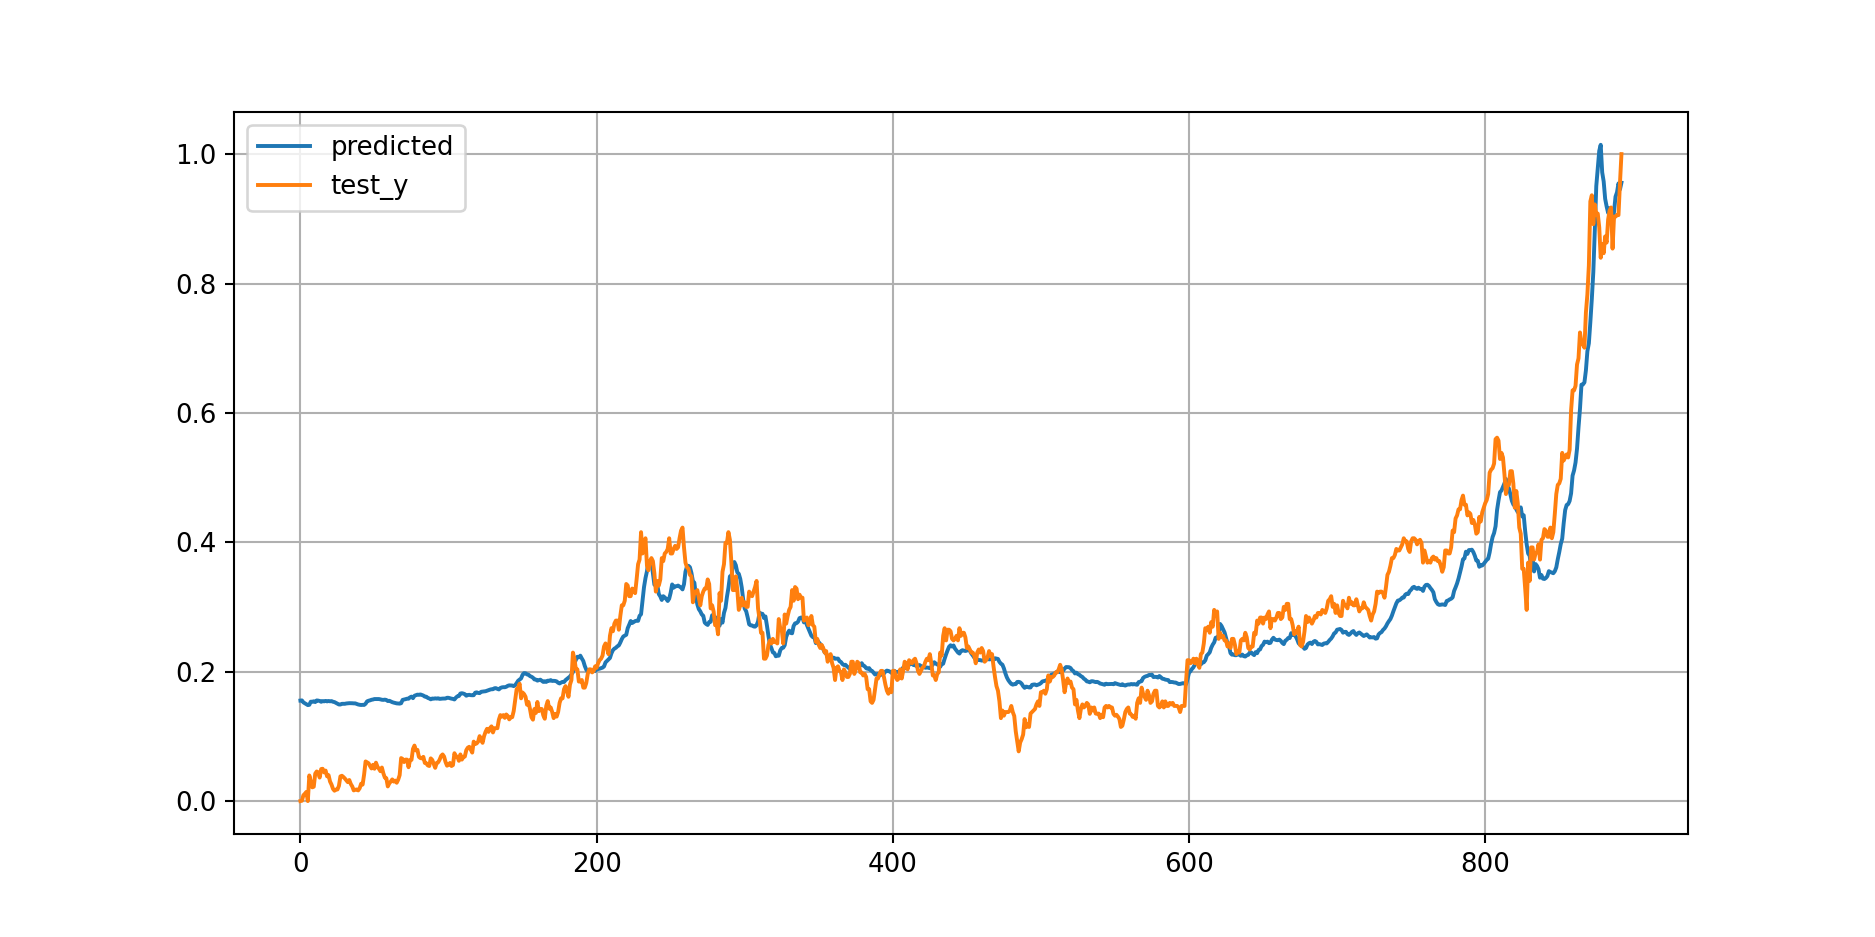

In [173]:
%matplotlib qt5

print(model)
print('batch_size :',batch_size, ' layers: ', layers)
plt.figure(figsize=(10,5))
plt.plot(predicted.cpu())
plt.plot(test_y.cpu())
plt.legend(['predicted', 'test_y'])
plt.grid(True)
#plt.xticks([20*i for i in range(0,46)])
plt.show()
    


In [ ]:
show_result_graph()